# SSD Evaluation for Leaf Detect



In [1]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set a few configuration parameters.
img_height = 300
img_width = 300
n_classes = 10
model_mode = 'inference'

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=n_classes,
                mode=model_mode,
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 256],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'ssd300_10leaf_detect_epoch-18.h5'
#weights_path = 'ssd7_leaf3_epoch-06_loss-1.8383_val_loss-1.9585.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 3

__________________________________________________________________________________________________
conv7_2_mbox_conf (Conv2D)      (None, 5, 5, 66)     152130      conv7_2[0][0]                    
__________________________________________________________________________________________________
conv8_2_mbox_conf (Conv2D)      (None, 3, 3, 44)     101420      conv8_2[0][0]                    
__________________________________________________________________________________________________
conv9_2_mbox_conf (Conv2D)      (None, 1, 1, 44)     101420      conv9_2[0][0]                    
__________________________________________________________________________________________________
conv4_3_norm_mbox_loc (Conv2D)  (None, 38, 38, 16)   73744       conv4_3_norm[0][0]               
__________________________________________________________________________________________________
fc7_mbox_loc (Conv2D)           (None, 19, 19, 24)   221208      fc7[0][0]                        
__________

Or

### 1.2. Load a trained model

We set `model_mode` to 'inference' above, so the evaluator expects that you load a model that was built in 'inference' mode. If you're loading a model that was built in 'training' mode, change the `model_mode` parameter accordingly.

## 2. Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [4]:
dataset = DataGenerator()


VOC_2019_images_dir      = '/hdd/data/LeafDetectData/LEAF2019/JPEGImages/'

VOC_2019_annotations_dir      = '/hdd/data/LeafDetectData/LEAF2019/Annotations/'

VOC_2019_trainval_image_set_filename = '/hdd/data/LeafDetectData/LEAF2019/ImageSets/Main/trainval.txt'

VOC_2019_test_image_set_filename     = '/hdd/data/LeafDetectData/LEAF2019/ImageSets/Main/test.txt'

classes = ['background','Potato_healthy','Potato_Early_blight','Infected_Potato_Early_blight',
           'Potato_Late_blight','Infected_Potato_Late_blight','Tomato_healthy',
           'Tomato_Early_blight','Infected_Tomato_Early_blight','Tomato_Late_blight','Infected_Tomato_Late_blight']


dataset.parse_xml(images_dirs=[VOC_2019_images_dir],
                  image_set_filenames=[VOC_2019_test_image_set_filename],
                  annotations_dirs=[VOC_2019_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Processing image set 'test.txt': 100%|██████████| 47/47 [00:00<00:00, 91.35it/s] 


## 3. Run the evaluation

Now that we have instantiated a model and a data generator to serve the dataset, we can set up the evaluator and run the evaluation.

The evaluator is quite flexible: It can compute the average precisions according to the Pascal VOC pre-2010 algorithm, which samples 11 equidistant points of the precision-recall curves, or according to the Pascal VOC post-2010 algorithm, which integrates numerically over the entire precision-recall curves instead of sampling a few individual points. You could also change the number of sampled recall points or the required IoU overlap for a prediction to be considered a true positive, among other things. Check out the `Evaluator`'s documentation for details on all the arguments.

In its default settings, the evaluator's algorithm is identical to the official Pascal VOC pre-2010 Matlab detection evaluation algorithm, so you don't really need to tweak anything unless you want to.

The evaluator roughly performs the following steps: It runs predictions over the entire given dataset, then it matches these predictions to the ground truth boxes, then it computes the precision-recall curves for each class, then it samples 11 equidistant points from these precision-recall curves to compute the average precision for each class, and finally it computes the mean average precision over all classes.

In [5]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=False,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 47

Producing predictions batch-wise: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]
Matching predictions to ground truth, class 1/10.: 100%|██████████| 13/13 [00:00<00:00, 6325.52it/s]
Matching predictions to ground truth, class 2/10.: 100%|██████████| 1695/1695 [00:00<00:00, 11395.54it/s]
Matching predictions to ground truth, class 3/10.: 100%|██████████| 12/12 [00:00<00:00, 6823.70it/s]
Matching predictions to ground truth, class 4/10.: 100%|██████████| 1417/1417 [00:00<00:00, 6113.23it/s]
Matching predictions to ground truth, class 5/10.: 100%|██████████| 31/31 [00:00<00:00, 4021.38it/s]
Matching predictions to ground truth, class 6/10.: 100%|██████████| 18/18 [00:00<00:00, 3560.87it/s]
Matching predictions to ground truth, class 7/10.: 100%|██████████| 1624/1624 [00:00<00:00, 12374.35it/s]
Matching predictions to ground truth, class 8/10.: 100%|██████████| 23/23 [00:00<00:00, 7146.91it/s]
Matching predictions to ground truth, class 9/10.:

## 4. Visualize the results

Let's take a look:

In [6]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

Potato_healthyAP    0.777
Potato_Early_blightAP    0.004
Infected_Potato_Early_blightAP    0.683
Potato_Late_blightAP    0.073
Infected_Potato_Late_blightAP    0.711
Tomato_healthyAP    1.0
Tomato_Early_blightAP    0.023
Infected_Tomato_Early_blightAP    0.639
Tomato_Late_blightAP    0.038
Infected_Tomato_Late_blightAP    0.623

              mAP   0.457


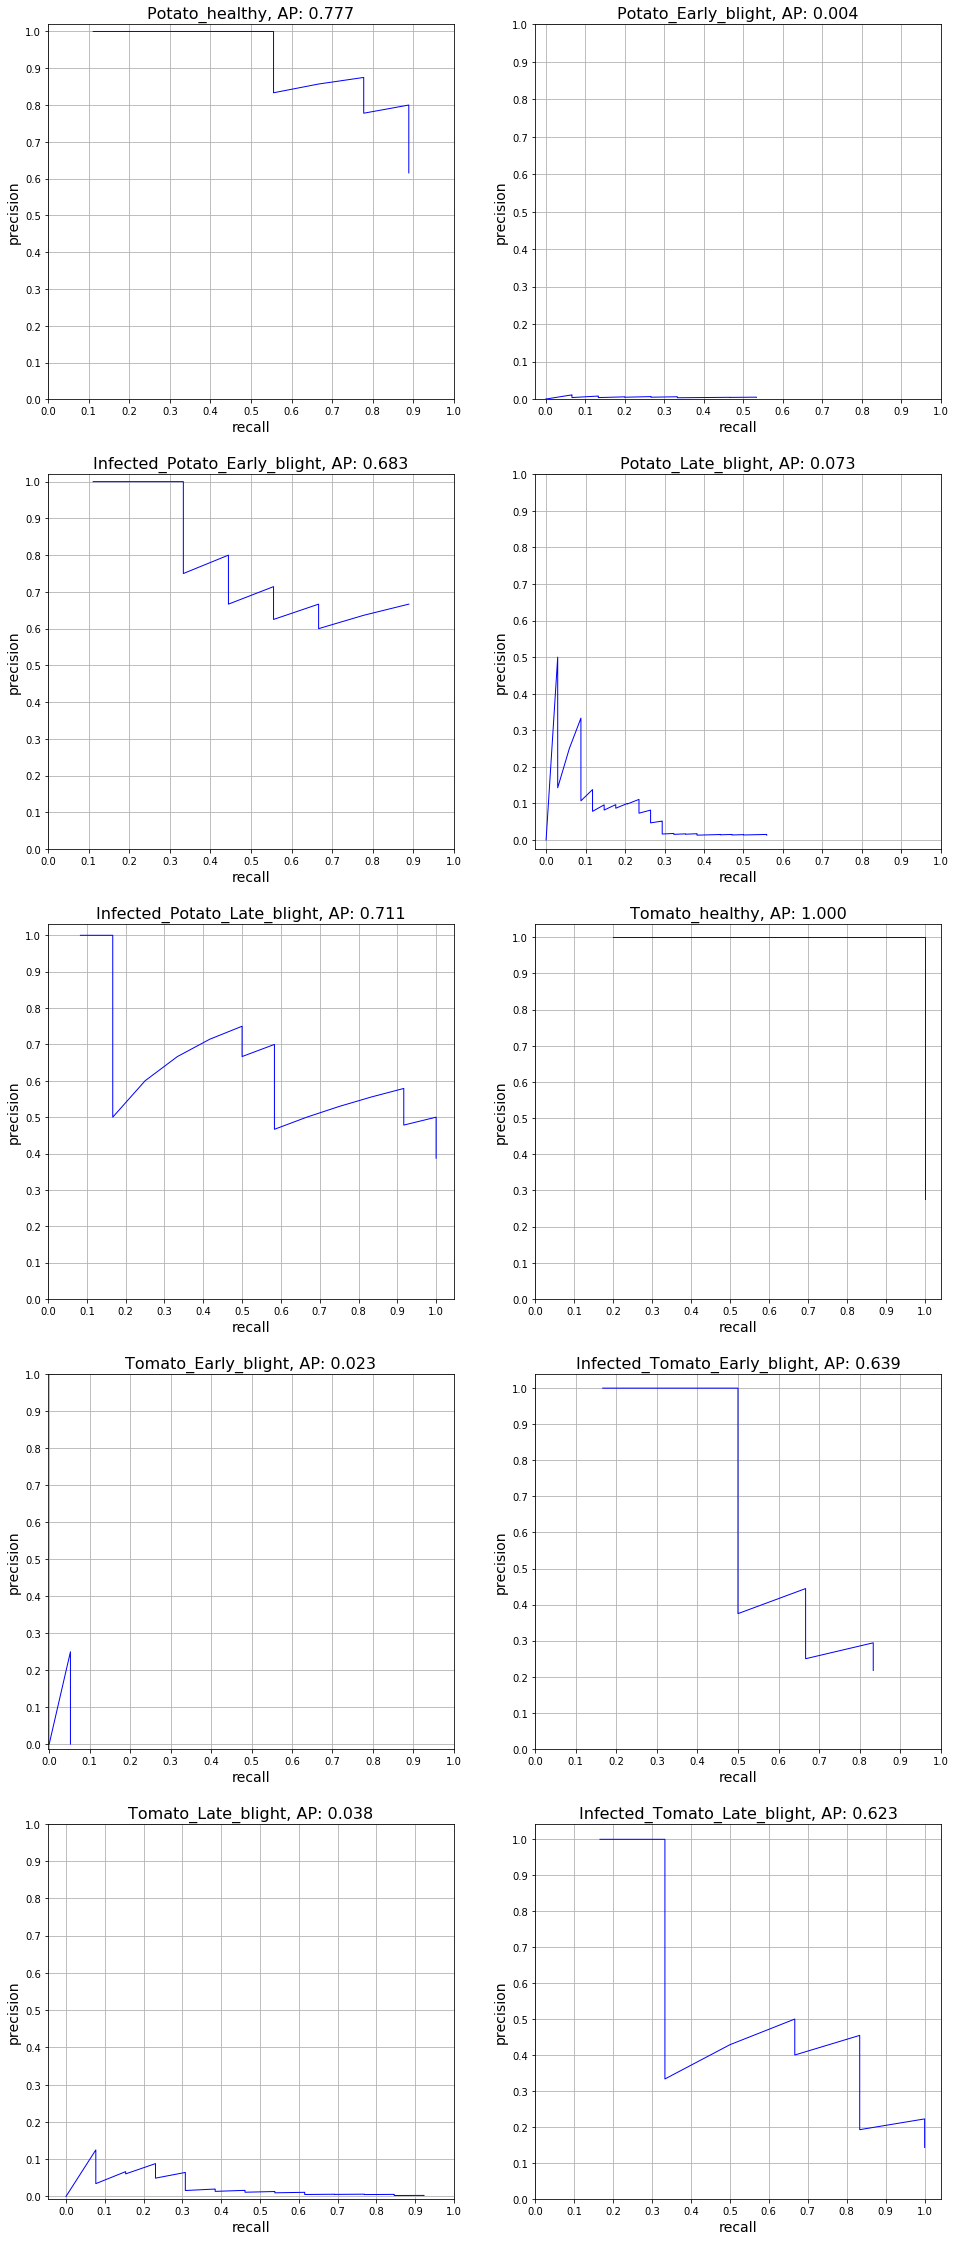

In [7]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

## 5. Advanced use

`Evaluator` objects maintain copies of all relevant intermediate results like predictions, precisions and recalls, etc., so in case you want to experiment with different parameters, e.g. different IoU overlaps, there is no need to compute the predictions all over again every time you make a change to a parameter. Instead, you can only update the computation from the point that is affected onwards.

The evaluator's `__call__()` method is just a convenience wrapper that executes its other methods in the correct order. You could just call any of these other methods individually as shown below (but you have to make sure to call them in the correct order).

Note that the example below uses the same evaluator object as above. Say you wanted to compute the Pascal VOC post-2010 'integrate' version of the average precisions instead of the pre-2010 version computed above. The evaluator object still has an internal copy of all the predictions, and since computing the predictions makes up the vast majority of the overall computation time and since the predictions aren't affected by changing the average precision computation mode, we skip computing the predictions again and instead only compute the steps that come after the prediction phase of the evaluation. We could even skip the matching part, since it isn't affected by changing the average precision mode either. In fact, we would only have to call `compute_average_precisions()` `compute_mean_average_precision()` again, but for the sake of illustration we'll re-do the other computations, too.

In [8]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

Matching predictions to ground truth, class 1/10.: 100%|██████████| 13/13 [00:00<00:00, 1725.34it/s]
Matching predictions to ground truth, class 2/10.: 100%|██████████| 1695/1695 [00:00<00:00, 10039.99it/s]
Matching predictions to ground truth, class 3/10.: 100%|██████████| 12/12 [00:00<00:00, 6285.96it/s]
Matching predictions to ground truth, class 4/10.: 100%|██████████| 1417/1417 [00:00<00:00, 9512.48it/s]
Matching predictions to ground truth, class 5/10.: 100%|██████████| 31/31 [00:00<00:00, 2030.00it/s]
Matching predictions to ground truth, class 6/10.: 100%|██████████| 18/18 [00:00<00:00, 9804.87it/s]
Matching predictions to ground truth, class 7/10.: 100%|██████████| 1624/1624 [00:00<00:00, 11380.35it/s]
Matching predictions to ground truth, class 8/10.: 100%|██████████| 23/23 [00:00<00:00, 9886.14it/s]
Matching predictions to ground truth, class 9/10.: 100%|██████████| 4525/4525 [00:00<00:00, 13699.63it/s]
Matching predictions to ground truth, class 10/10.: 100%|██████████| 42/

In [10]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], ' AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

Potato_healthy AP   0.75
Potato_Early_blight AP   0.004
Infected_Potato_Early_blight AP   0.646
Potato_Late_blight AP   0.074
Infected_Potato_Late_blight AP   0.668
Tomato_healthy AP   0.8
Tomato_Early_blight AP   0.0
Infected_Tomato_Early_blight AP   0.574
Tomato_Late_blight AP   0.044
Infected_Tomato_Late_blight AP   0.576

              mAP   0.414
